In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [25]:
from pandas import *
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader
import numpy as np
import math

In [3]:
n_epochs = 5
batch_size_train = 64
batch_size_test = 10000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

In [4]:
transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
transform

Compose(
    ToTensor()
    Normalize(mean=(0.1307,), std=(0.3081,))
)

In [5]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

train_set = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_set, batch_size=batch_size_train, shuffle=True)



100%|██████████| 9912422/9912422 [00:00<00:00, 114823704.08it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 58294366.61it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34351534.55it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4753125.94it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
test_set = MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_set, batch_size=batch_size_test, shuffle=False)

In [7]:
# Get a batch of data (in this case, just one batch)
data_iterator = iter(train_loader)
images, labels = next(data_iterator)



Text(0.5, 1.0, 'Number: 9')

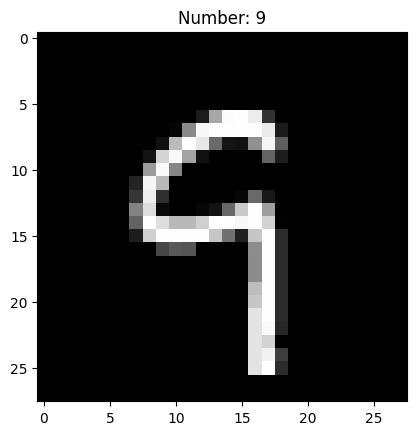

In [8]:
# Plot the first image in the batch
plt.imshow(images[63][0], cmap="gray")

# Add the label (number) as the title
plt.title(f"Number: {labels[63]}")

In [29]:
# Define the CNN model
class myCNN(nn.Module):
    def __init__(self, kernelSize=2):
        super(myCNN, self).__init__()
        self.kernelSize = kernelSize
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=kernelSize)
        self.pool = nn.MaxPool2d(kernelSize)

        self.conv1_out = (28-kernelSize) + 1 # here stride size is 1
        self.pool_out = ((self.conv1_out - kernelSize) / kernelSize) +1 #here both kernel and stride size are same
        self.input = math.floor(self.pool_out)

        self.fc1 = nn.Linear(5 * self.input * self.input, (self.input // 2))
        self.fc2 = nn.Linear((self.input // 2), 10)

    def forward(self, x):
        self.features = F.relu(self.conv1(x))
        x = self.pool(self.features)
        in_size = np.product(x.shape[1:])
        x = x.view(-1, in_size)
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x))
        return x

In [42]:
from torchsummary import summary

model = myCNN(kernelSize=2)

# Print the model summary
summary(model, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 27, 27]              25
         MaxPool2d-2            [-1, 5, 13, 13]               0
            Linear-3                    [-1, 6]           5,076
            Linear-4                   [-1, 10]              70
Total params: 5,171
Trainable params: 5,171
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.02
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


<ipython-input-29-539433dc107d>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc2(x))


In [30]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [31]:
# Training function
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

    # Compute training accuracy at the end of the epoch
    correct_train = 0
    total_train = 0
    with torch.no_grad():
        for data, target in train_loader:
            output = network(data)
            _, predicted = torch.max(output.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

    train_acc = 100 * correct_train / total_train
    trainAccuracy.append(train_acc)
    print(f'Training Accuracy (Epoch {epoch}): {train_acc:.2f}%')

# Testing function
def test():
    network.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            _, predicted = torch.max(output.data, 1)
            total_test += target.size(0)
            correct_test += (predicted == target).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    test_acc = 100 * correct_test / total_test
    testAccuracy.append(test_acc)
    print(f'Test Accuracy (Epoch {epoch}): {test_acc:.2f}%')


In [32]:
# Kernel sizes to iterate over
kernelSizes = [2, 3, 4, 5]


In [33]:
# Lists to store training and testing accuracy for different kernel sizes
trainAccuracies = []
testAccuracies = []

In [34]:
# Loop over different kernel sizes
for kernelSize in kernelSizes:
    print("Kernel Size = ", kernelSize)
    network = myCNN(kernelSize)  # Creating a new model for each kernel size
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

    trainAccuracy = []  # Initialize accuracy lists for each kernel size
    testAccuracy = []

    for epoch in range(1, n_epochs + 1):
        train(epoch)
        test()

    # Store the accuracy for this kernel size
    trainAccuracies.append(trainAccuracy)
    testAccuracies.append(testAccuracy)


Kernel Size =  2


<ipython-input-29-539433dc107d>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc2(x))


Training Accuracy (Epoch 1): 86.50%


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test Accuracy (Epoch 1): 86.71%
Training Accuracy (Epoch 2): 88.94%
Test Accuracy (Epoch 2): 88.83%
Training Accuracy (Epoch 3): 90.23%
Test Accuracy (Epoch 3): 90.18%
Training Accuracy (Epoch 4): 90.65%
Test Accuracy (Epoch 4): 90.59%
Training Accuracy (Epoch 5): 92.44%
Test Accuracy (Epoch 5): 92.42%
Kernel Size =  3
Training Accuracy (Epoch 1): 79.15%
Test Accuracy (Epoch 1): 79.90%
Training Accuracy (Epoch 2): 84.70%
Test Accuracy (Epoch 2): 85.30%
Training Accuracy (Epoch 3): 89.23%
Test Accuracy (Epoch 3): 89.47%
Training Accuracy (Epoch 4): 90.84%
Test Accuracy (Epoch 4): 90.97%
Training Accuracy (Epoch 5): 91.74%
Test Accuracy (Epoch 5): 91.68%
Kernel Size =  4
Training Accuracy (Epoch 1): 48.90%
Test Accuracy (Epoch 1): 49.56%
Training Accuracy (Epoch 2): 74.24%
Test Accuracy (Epoch 2): 75.10%
Training Accuracy (Epoch 3): 79.04%
Test Accuracy (Epoch 3): 80.06%
Training Accuracy (Epoch 4): 82.08%
Test Accuracy (Epoch 4): 83.02%
Training Accuracy (Epoch 5): 85.45%
Test Accuracy 

In [35]:

# Print the final train and test accuracies for different kernel sizes
for i, kernelSize in enumerate(kernelSizes):
    print(f'Kernel Size = {kernelSize}')
    print(f'Final Training Accuracy: {trainAccuracies[i][-1]:.2f}%')
    print(f'Final Test Accuracy: {testAccuracies[i][-1]:.2f}%')

Kernel Size = 2
Final Training Accuracy: 92.44%
Final Test Accuracy: 92.42%
Kernel Size = 3
Final Training Accuracy: 91.74%
Final Test Accuracy: 91.68%
Kernel Size = 4
Final Training Accuracy: 85.45%
Final Test Accuracy: 86.34%
Kernel Size = 5
Final Training Accuracy: 30.38%
Final Test Accuracy: 30.51%


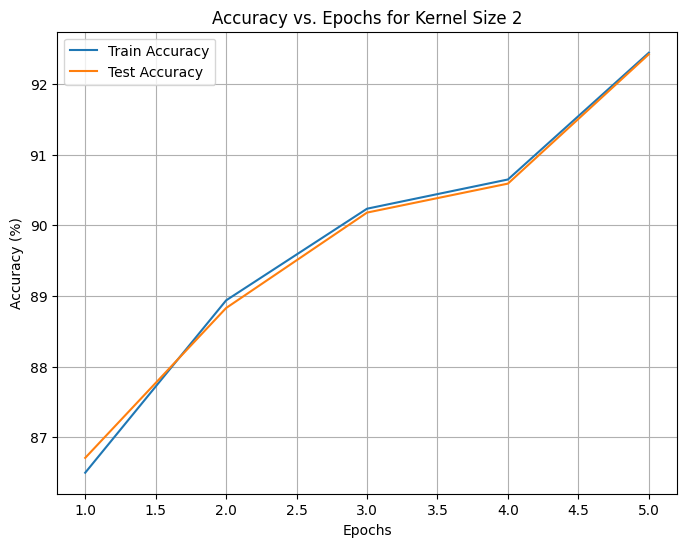

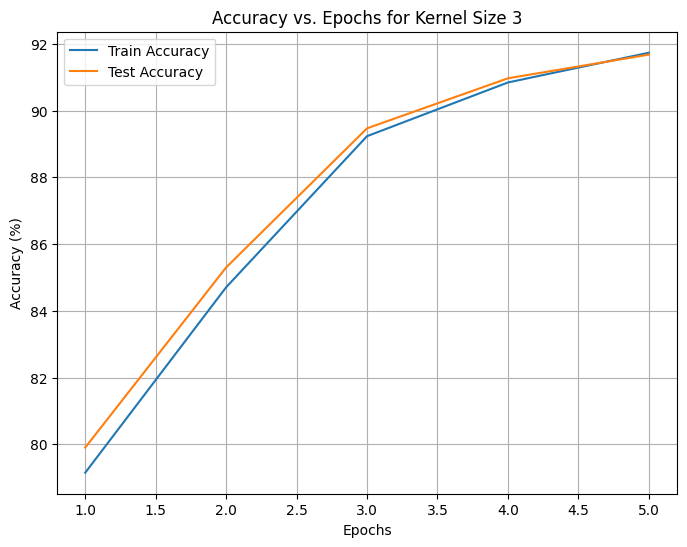

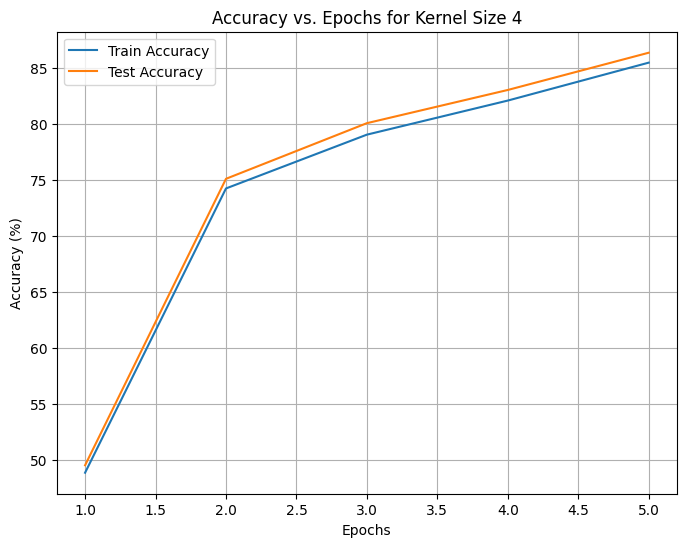

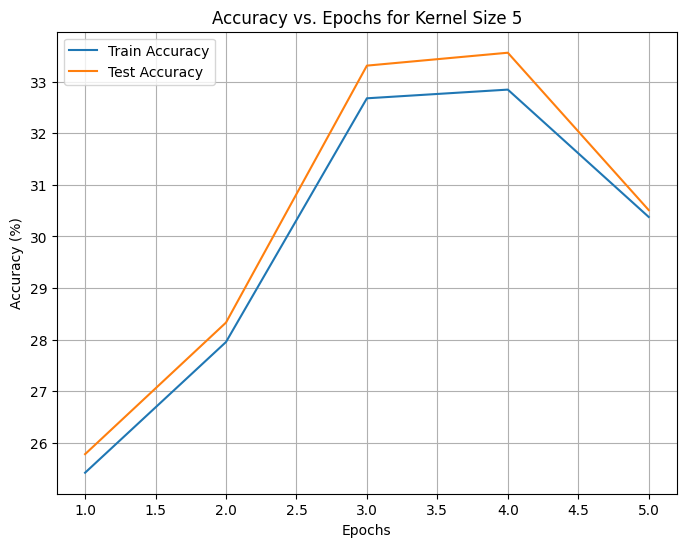

In [36]:
# Plot training and test accuracy for each kernel size
for i, kernelSize in enumerate(kernelSizes):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, n_epochs + 1), trainAccuracies[i], label='Train Accuracy')
    plt.plot(range(1, n_epochs + 1), testAccuracies[i], label='Test Accuracy')
    plt.title(f'Accuracy vs. Epochs for Kernel Size {kernelSize}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

**Analysis:**

1. **Kernel Size 2:** This kernel size achieved the highest training and test accuracy, indicating that it worked the best among the choices. A smaller kernel size typically captures finer details in the image, and this may have contributed to its superior performance on the MNIST dataset.

2. **Kernel Size 3:** This kernel size also performed reasonably well but had slightly lower accuracy compared to Kernel Size 2. It might have been less effective in capturing fine details but still performed decently.

3. **Kernel Size 4:** Kernel Size 4 achieved lower accuracy compared to the previous kernels. Larger kernel sizes may lead to a loss of detail in the feature extraction process, which could explain the drop in accuracy.

4. **Kernel Size 5:** Kernel Size 5 performed the worst among the choices. This is likely because the kernel size is too large for the MNIST dataset, and it effectively blurs the image features, making it challenging for the model to learn useful representations.

In summary, a smaller kernel size (e.g., 2) worked best for the MNIST dataset because it captured fine details in the handwritten digits. Larger kernel sizes (e.g., 4 and 5) led to a loss of detail and, consequently, poorer performance.

<ipython-input-29-539433dc107d>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc2(x))


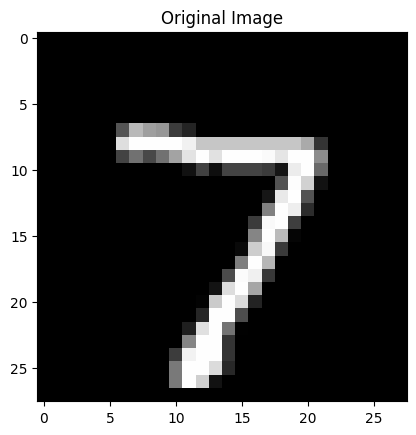

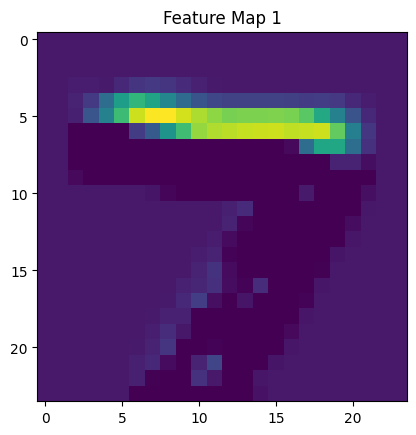

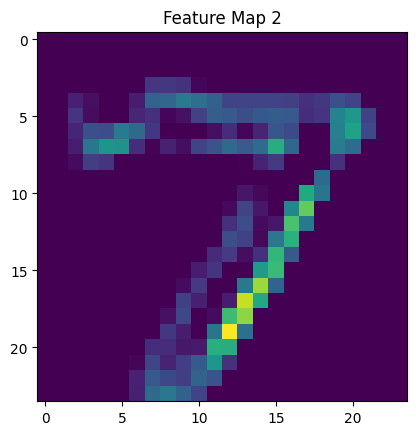

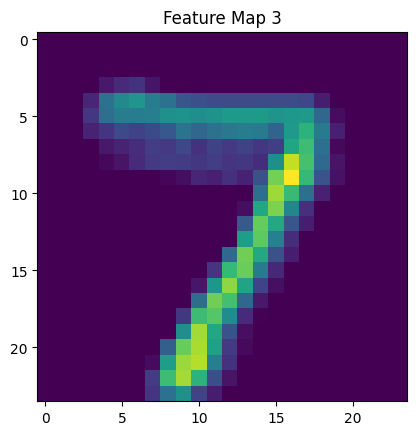

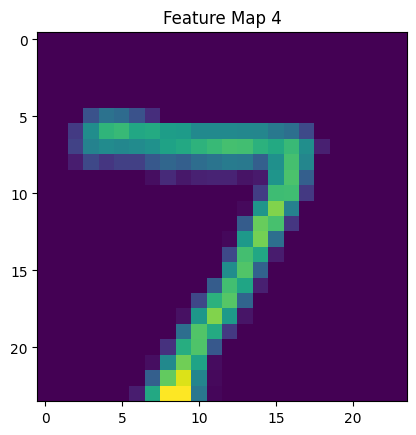

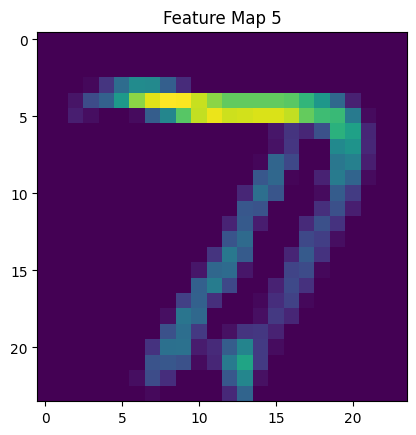

In [37]:
network.eval()  # Set the model to evaluation mode
image, label = next(iter(test_loader))  # Get a batch of images and labels from dataset

# Select the first image from the batch
input_image = image[0].unsqueeze(0)

# Forward pass
output = network(input_image)

# Get the feature maps
feature_maps = network.features.squeeze(0).detach().numpy()

# Plot the original image
plt.imshow(input_image.squeeze(0).squeeze(0), cmap="gray")
plt.title("Original Image")
plt.show()

# Plot each feature map
num_feature_maps = feature_maps.shape[0]
for i in range(num_feature_maps):
    plt.imshow(feature_maps[i], cmap="viridis")
    plt.title(f"Feature Map {i+1}")
    plt.show()


In [43]:
kernel_values = model.conv1.weight.detach().numpy()
print("Kernel Values:")
print(kernel_values)

Kernel Values:
[[[[-0.2312538   0.41687834]
   [ 0.01038438 -0.15065938]]]


 [[[-0.14175999 -0.39678437]
   [ 0.32357275  0.42800713]]]


 [[[ 0.38699794  0.40210497]
   [-0.11922395 -0.30288714]]]


 [[[-0.07916075  0.25889897]
   [ 0.07058895  0.00284219]]]


 [[[-0.39608586  0.04960239]
   [-0.11900681 -0.21824187]]]]


 I  made some general observations about what convolutional kernels with certain weight patterns tend to capture in images:

1. **Edge Detection**: Kernels with this weight patterns is involved in detecting edges:
   
   ```
   [[-0.231,  0.417],
    [ 0.010, -0.151]]
   ```

   These kernels highlight edges in different orientations.

2. **Texture Detection**: Kernels with this weights focuses on detecting textures or patterns:

   ```
   [[-0.142, -0.397],
    [ 0.324,  0.428]]
   ```

3. **Corner and Junction Detection**: Kernels with this weight patterns  captures corners:

   ```
   [[-0.079,  0.259],
    [ 0.071,  0.003]]
   ```

4. **Structure and Orientation Detection**: Kernels with this weights  focused on detecting specific orientations:

   ```
   [[ 0.387,  0.402],
    [-0.119, -0.303]]
   ```

5. **General Features**: Kernels with this weight values captures abstract features that are a combination of various patterns.

